In [0]:
from pyspark.sql import SparkSession

# Khởi tạo SparkSession
spark = SparkSession.builder.appName("Build Moldel  from Azure").getOrCreate()

# Đường dẫn thư mục Delta Lake trên Azure Blob Storage
delta_path = "link_storage"

# Cấu hình tài khoản Azure Blob Storage
spark.conf.set(
    "fs.azure.account.key.tikistoragedata123.blob.core.windows.net",
    "key"
)

try:
    df = spark.read.format("delta").load(delta_path)
    df.show(10)  
    df.printSchema()  
except Exception as e:
    print(f"Lỗi khi đọc Delta Lake: {e}")


+---------+-------------+--------------------+-------+----------+--------+-------------+--------------+------------+-----------+---------------+--------------------+-------------+--------------+---------+-----------------+----------+--------------------+--------------------+--------------------+--------------------+------------------------+
|       id|          sku|                name|  price|list_price|discount|discount_rate|rating_average|review_count|order_count|favourite_count|       thumbnail_url|quantity_sold|original_price|seller_id|seller_product_id|brand_name|    category_l1_name|    category_l2_name|    category_l3_name|      processed_time|calculated_discount_rate|
+---------+-------------+--------------------+-------+----------+--------+-------------+--------------+------------+-----------+---------------+--------------------+-------------+--------------+---------+-----------------+----------+--------------------+--------------------+--------------------+------------------

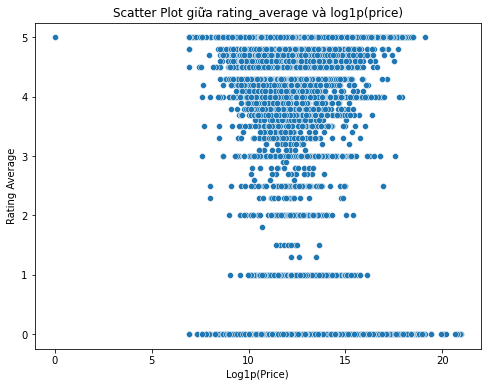

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Lấy các cột cần thiết từ df và chuyển đổi sang DataFrame Pandas
df_pandas = df.select(['price', 'rating_average', 'list_price', 'discount', 'discount_rate','quantity_sold','category_l1_name','brand_name','category_l2_name','category_l3_name']).toPandas()

# Xử lý cột 'price' bằng cách áp dụng hàm np.log1p()
df_pandas['price_log1p'] = np.log1p(df_pandas['price'])

# Vẽ Scatter Plot giữa rating_average và log1p(price)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='price_log1p', y='rating_average', data=df_pandas)
plt.title('Scatter Plot giữa rating_average và log1p(price)')
plt.xlabel('Log1p(Price)')
plt.ylabel('Rating Average')
plt.show()


In [0]:
# Làm tròn discount_rate thành các nhóm 0, 25, 50, 75, 100
def categorize_discount_rate(rate):
    if rate == 0:
        return 0
    elif rate <= 25:
        return 25
    elif rate <= 50:
        return 50
    elif rate <= 75:
        return 75
    else:
        return 100

# Áp dụng hàm lên cột discount_rate
df_pandas['discount_rate_group'] = df_pandas['discount_rate'].apply(categorize_discount_rate)


In [0]:
df_pandas['discount_rate_group'].value_counts().sort_index()


Out[106]: 0      26415
25     13851
50      8453
75      1682
100       22
Name: discount_rate_group, dtype: int64

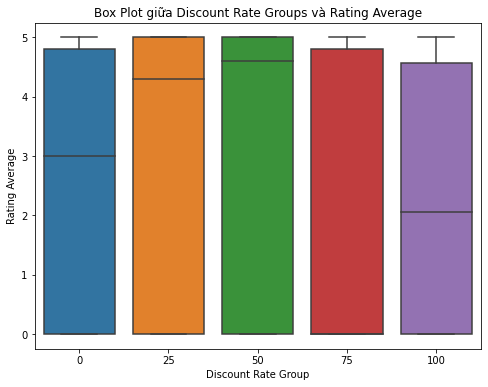

In [0]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='discount_rate_group', y='rating_average', data=df_pandas)
plt.title('Box Plot giữa Discount Rate Groups và Rating Average')
plt.xlabel('Discount Rate Group')
plt.ylabel('Rating Average')
plt.show()


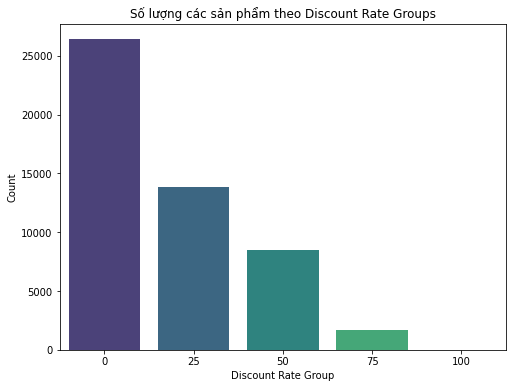

In [0]:
plt.figure(figsize=(8, 6))
sns.countplot(x='discount_rate_group', data=df_pandas, palette='viridis')
plt.title('Số lượng các sản phẩm theo Discount Rate Groups')
plt.xlabel('Discount Rate Group')
plt.ylabel('Count')
plt.show()


In [0]:
df_pandas['rating_average'].value_counts()

Out[109]: 0.0    22532
5.0    12471
4.8     3551
4.5     2773
4.7     2601
4.6     1765
4.0     1476
4.3      906
4.2      391
3.0      380
1.0      288
4.1      242
3.7      185
3.8      178
3.5      136
3.9      126
2.0      115
3.3       78
2.5       60
3.6       41
3.4       37
2.3       20
3.2       19
2.8       12
2.7       11
3.1       11
1.5        8
1.3        3
2.9        3
2.6        3
1.8        1
Name: rating_average, dtype: int64

In [0]:
# Loại bỏ các hàng có rating_average = 0
df_pandas = df_pandas[df_pandas['rating_average'] > 0]


In [0]:
def categorize_rating(rating):
    if rating < 2.5:
        return 'Low'
    elif rating < 4.5:
        return 'Medium'
    else:
        return 'High'

df_pandas['rating_category'] = df_pandas['rating_average'].apply(categorize_rating)


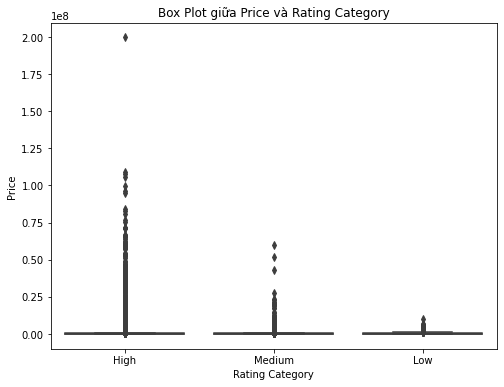

In [0]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='rating_category', y='price', data=df_pandas)
plt.title('Box Plot giữa Price và Rating Category')
plt.xlabel('Rating Category')
plt.ylabel('Price')
plt.show()


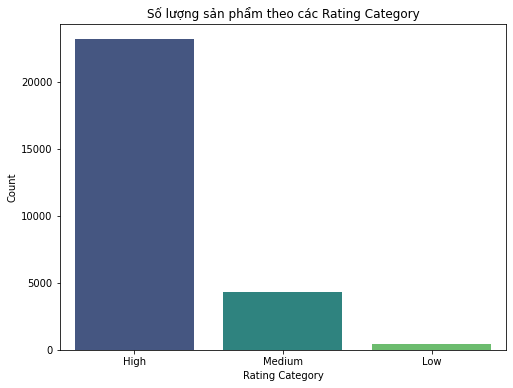

In [0]:
plt.figure(figsize=(8, 6))
sns.countplot(x='rating_category', data=df_pandas, palette='viridis')
plt.title('Số lượng sản phẩm theo các Rating Category')
plt.xlabel('Rating Category')
plt.ylabel('Count')
plt.show()


In [0]:
from sklearn.preprocessing import LabelEncoder

# Khởi tạo LabelEncoder
le = LabelEncoder()

# Danh sách các cột cần mã hóa
columns_to_encode = ['category_l1_name', 'brand_name', 'category_l2_name', 'category_l3_name']

# Áp dụng LabelEncoder cho từng cột trong danh sách
for column in columns_to_encode:
    df_pandas[column + '_encoded'] = le.fit_transform(df_pandas[column].fillna('Unknown'))

# Hiển thị mapping giữa các giá trị chuỗi và giá trị số
for column in columns_to_encode:
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"{column} mapping: {mapping}")


category_l1_name mapping: {'Adapter - Củ Sạc': 0, 'Ba lô, Túi xách & Cặp cho bé': 1, 'Balo & túi chống sốc': 2, 'Balo dã ngoại và leo núi chuyên dụng': 3, 'Bao Da - Ốp Lưng': 4, 'Bida': 5, 'Boardgame': 6, 'Bookmark': 7, 'Buffet': 8, 'Business & Economics': 9, 'Bàn Phím Rời - Bút Cảm Ứng': 10, 'Bàn chải đánh răng': 11, 'Bàn ủi, bàn là': 12, 'Bánh': 13, 'Bánh bao, há cảo, mandu': 14, 'Bình lọc, lõi lọc, thiết bị lọc nước': 15, 'Bình, ly uống cà phê và phụ kiện': 16, 'Bình, ly uống trà và phụ kiện': 17, 'Bình/ Ly giữ nhiệt': 18, 'Bóng bàn': 19, 'Bóng chuyền': 20, 'Bóng chày': 21, 'Bóng rổ và dụng cụ bóng rổ': 22, 'Bóng và linh kiện đèn': 23, 'Bóng Đá': 24, 'Búp bê, Thú bông': 25, 'Bút - Viết các loại': 26, 'Bút Chì Màu - Bút Lông Màu - Sáp Màu': 27, 'Băng vệ sinh, cốc nguyệt san': 28, 'Bơi lội': 29, 'Bảo hộ lao động': 30, 'Bảo vệ nhà cửa': 31, 'Bếp các loại': 32, 'Bếp nướng, vỉ nướng': 33, 'Bộ hộp cơm và phụ kiện': 34, 'Bộ trang phục': 35, 'Bột nặn, Cát nặn': 36, 'Chocolate': 37, 'Chân Má

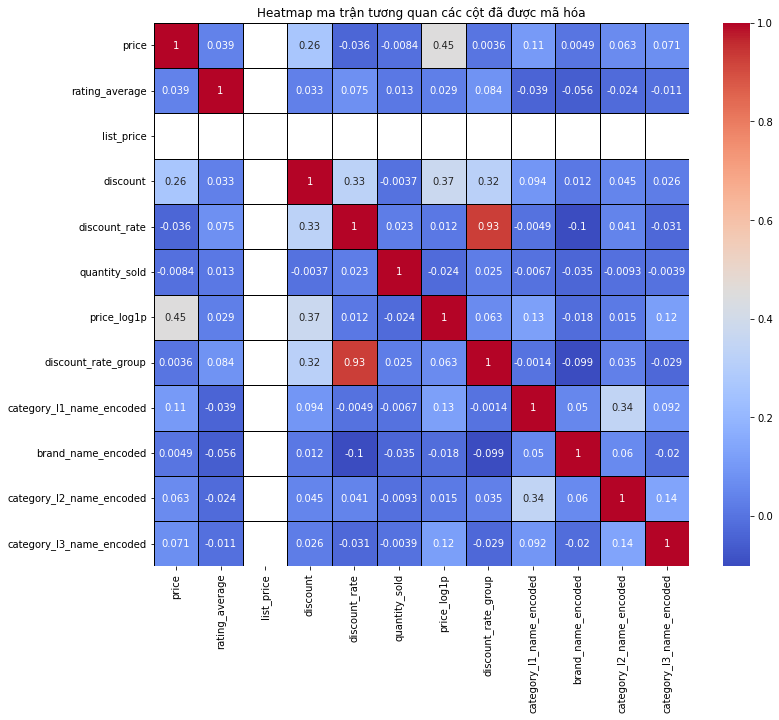

In [0]:
# Tính ma trận tương quan giữa các cột số trong DataFrame
correlation_matrix = df_pandas.corr()

# Vẽ Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=1, linecolor='black')
plt.title('Heatmap ma trận tương quan các cột đã được mã hóa')
plt.show()


In [0]:
df_pandas.columns

Out[118]: Index(['price', 'rating_average', 'list_price', 'discount', 'discount_rate',
       'quantity_sold', 'category_l1_name', 'brand_name', 'category_l2_name',
       'category_l3_name', 'price_log1p', 'discount_rate_group',
       'rating_category', 'category_l1_name_encoded', 'brand_name_encoded',
       'category_l2_name_encoded', 'category_l3_name_encoded'],
      dtype='object')

## build model

###  Linear Regression

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X = df_pandas[['rating_average', 'discount', 'discount_rate', 
                'category_l1_name_encoded', 
                'category_l2_name_encoded', 'category_l3_name_encoded']]

y = df_pandas['price_log1p']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R2 Score: {r2}')

print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')


Root Mean Squared Error (RMSE): 1.207828105285102
R2 Score: 0.15966286898088966
Coefficients: [ 5.96519815e-02  1.17536450e-06 -9.45992021e-03  1.66006877e-02
 -1.05229321e-03  1.19506350e-03]
Intercept: 11.530072442690285


### RandomForest

In [0]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f'RandomForest RMSE: {rmse_rf}')
print(f'RandomForest R2: {r2_rf}')


RandomForest RMSE: 0.6915315508999845
RandomForest R2: 0.7245344518833535
